# Introducción al Proyecto: Análisis del Comportamiento del Usuario en una Aplicación de Productos Alimenticios

En este proyecto, trabajamos para una empresa emergente que se dedica a la venta de productos alimenticios. El objetivo principal es comprender el comportamiento de los usuarios en la aplicación de la empresa. A través de un análisis detallado, exploraremos el embudo de ventas y realizaremos un test A/A/B para evaluar el impacto de un cambio en el diseño de la aplicación.

## Preparación de datos 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [2]:
datos = pd.read_csv("/datasets/logs_exp_us.csv", sep='\t')

datos.columns = ['nombre_evento', 'id_usuario_unico', 'hora_evento', 'num_experimento']

print(datos.head())

datos.info()

             nombre_evento     id_usuario_unico  hora_evento  num_experimento
0         MainScreenAppear  4575588528974610257   1564029816              246
1         MainScreenAppear  7416695313311560658   1564053102              246
2  PaymentScreenSuccessful  3518123091307005509   1564054127              248
3         CartScreenAppear  3518123091307005509   1564054127              248
4  PaymentScreenSuccessful  6217807653094995999   1564055322              248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   nombre_evento     244126 non-null  object
 1   id_usuario_unico  244126 non-null  int64 
 2   hora_evento       244126 non-null  int64 
 3   num_experimento   244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Los nombres de las columnas se han cambiado correctamente de la siguiente forma: 

EventName: nombre del evento.

DeviceIDHash: identificador de usuario unívoco.

EventTimestamp: hora del evento.

ExpId: número de experimento.

In [3]:
# Verificar tipos de datos
print("Tipos de datos:")
print(datos.dtypes)

# Verificar valores ausentes
print("\nValores ausentes:")
print(datos.isnull().sum())

Tipos de datos:
nombre_evento       object
id_usuario_unico     int64
hora_evento          int64
num_experimento      int64
dtype: object

Valores ausentes:
nombre_evento       0
id_usuario_unico    0
hora_evento         0
num_experimento     0
dtype: int64


Parece que no hay valores ausentes en tus datos, y los tipos de datos son apropiados. No hay necesidad de correcciones en este paso.

In [4]:
# Convertir la columna 'hora del evento' a formato de fecha y hora
datos['fecha_hora'] = pd.to_datetime(datos['hora_evento'], unit='s')

# Agregar columnas separadas para la fecha
datos['fecha'] = datos['fecha_hora'].dt.date
datos['hora'] = datos['fecha_hora'].dt.time

print(datos.head())

             nombre_evento     id_usuario_unico  hora_evento  num_experimento  \
0         MainScreenAppear  4575588528974610257   1564029816              246   
1         MainScreenAppear  7416695313311560658   1564053102              246   
2  PaymentScreenSuccessful  3518123091307005509   1564054127              248   
3         CartScreenAppear  3518123091307005509   1564054127              248   
4  PaymentScreenSuccessful  6217807653094995999   1564055322              248   

           fecha_hora       fecha      hora  
0 2019-07-25 04:43:36  2019-07-25  04:43:36  
1 2019-07-25 11:11:42  2019-07-25  11:11:42  
2 2019-07-25 11:28:47  2019-07-25  11:28:47  
3 2019-07-25 11:28:47  2019-07-25  11:28:47  
4 2019-07-25 11:48:42  2019-07-25  11:48:42  


Las nuevas columnas fecha_hora, fecha, y hora se han agregado correctamente al DataFrame. 

## Estudiar y comprobar los datos

In [5]:
# Contar el número de eventos
num_eventos = datos['nombre_evento'].nunique()

print(f"El número de eventos en los registros es: {num_eventos}")

# Contar el número de usuarios y usuarias únicos
num_usuarios = datos['id_usuario_unico'].nunique()

print(f"El número de usuarios y usuarias en los registros es: {num_usuarios}")

# Calcular el promedio de eventos por usuario
promedio_eventos_por_usuario = datos.groupby('id_usuario_unico')['nombre_evento'].count().mean()

print(f"El promedio de eventos por usuario es: {promedio_eventos_por_usuario:.2f}")

El número de eventos en los registros es: 5
El número de usuarios y usuarias en los registros es: 7551
El promedio de eventos por usuario es: 32.33


Fecha máxima: 2019-08-07 21:15:17
Fecha mínima: 2019-07-25 04:43:36


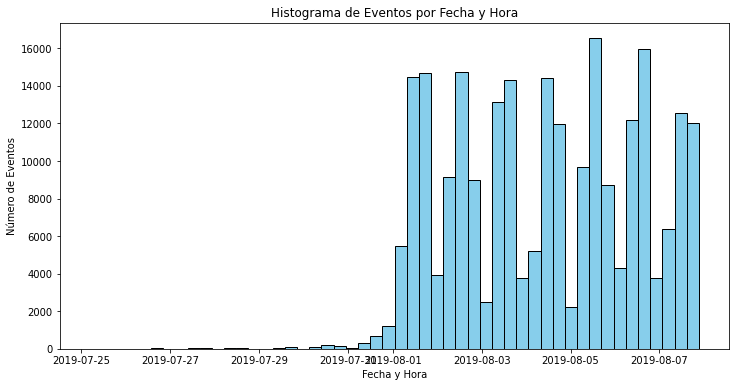

In [6]:
# Encontrar la fecha máxima y mínima
fecha_maxima = datos['fecha_hora'].max()
fecha_minima = datos['fecha_hora'].min()

print(f"Fecha máxima: {fecha_maxima}")
print(f"Fecha mínima: {fecha_minima}")


plt.figure(figsize=(12, 6))
plt.hist(datos['fecha_hora'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Eventos')
plt.title('Histograma de Eventos por Fecha y Hora')
plt.show()

In [7]:
# Contar la cantidad de eventos por fecha
eventos_por_fecha = datos.groupby('fecha')['nombre_evento'].count()

# Calcular la variación porcentual entre eventos por fecha
variacion_porcentual = eventos_por_fecha.pct_change()

print("Variación porcentual entre eventos por fecha:")
print(variacion_porcentual)

# Verificar si hay variaciones significativas
if variacion_porcentual.abs().max() <= 0.1:
    print("Los datos son relativamente estables a lo largo del periodo.")
else:
    print("Puede haber variaciones significativas en los datos a lo largo del periodo.")


Variación porcentual entre eventos por fecha:
fecha
2019-07-25          NaN
2019-07-26     2.444444
2019-07-27     0.774194
2019-07-28     0.909091
2019-07-29     0.752381
2019-07-30     1.244565
2019-07-31     3.917676
2019-08-01    16.838011
2019-08-02    -0.017196
2019-08-03    -0.063332
2019-08-04    -0.009535
2019-08-05     0.093240
2019-08-06    -0.008058
2019-08-07    -0.130590
Name: nombre_evento, dtype: float64
Puede haber variaciones significativas en los datos a lo largo del periodo.


Los resultados indican que hay variaciones significativas en la cantidad de eventos a lo largo del periodo. La variación porcentual entre algunas fechas supera el 10%, lo que sugiere fluctuaciones notables en la actividad de los usuarios en diferentes días.

Dado que hay variaciones significativas, es recomendable considerar estas fluctuaciones al interpretar los resultados del análisis y al tomar decisiones basadas en los datos.

In [8]:
# Establecer un umbral de variación porcentual
umbral_variacion = 0.1

# Filtrar las fechas a partir del momento en que la variación porcentual es menor al umbral
fechas_completas = variacion_porcentual[variacion_porcentual.abs() <= umbral_variacion].index

# Encontrar la fecha a partir de la cual los datos son relativamente estables
fecha_inicio_datos_completos = fechas_completas.min()

print(f"Los datos son relativamente estables a partir de la fecha: {fecha_inicio_datos_completos}")

Los datos son relativamente estables a partir de la fecha: 2019-08-02


Parece que los datos se vuelven relativamente estables a partir del 2 de agosto de 2019.

In [9]:
# Crear un DataFrame con datos completos (a partir de la fecha establecida)
fecha_inicio_datos_completos = pd.to_datetime(fecha_inicio_datos_completos)
datos_completos = datos[datos['fecha_hora'] >= fecha_inicio_datos_completos]

# Estadísticas antes del filtrado
num_eventos_antes = datos['nombre_evento'].nunique()
num_usuarios_antes = datos['id_usuario_unico'].nunique()

# Estadísticas después del filtrado
num_eventos_despues = datos_completos['nombre_evento'].nunique()
num_usuarios_despues = datos_completos['id_usuario_unico'].nunique()

print(f"Número de eventos antes del filtrado: {num_eventos_antes}")
print(f"Número de usuarios antes del filtrado: {num_usuarios_antes}")
print(f"Número de eventos después del filtrado: {num_eventos_despues}")
print(f"Número de usuarios después del filtrado: {num_usuarios_despues}")

Número de eventos antes del filtrado: 5
Número de usuarios antes del filtrado: 7551
Número de eventos después del filtrado: 5
Número de usuarios después del filtrado: 7286


Parece que al excluir los datos más antiguos, se perdieron algunos eventos y usuarios en el proceso. Es normal que la cantidad de usuarios disminuya, ya que algunos podrían haber participado en eventos más antiguos que fueron excluidos.

In [10]:
# Verificar la distribución de usuarios en los tres grupos experimentales
distribucion_exp = datos_completos['num_experimento'].value_counts()

# Mostrar los resultados
print("Distribución de usuarios en los grupos experimentales:")
print(distribucion_exp) 

Distribución de usuarios en los grupos experimentales:
248    72414
246    67844
247    64811
Name: num_experimento, dtype: int64


La distribución de usuarios en los grupos experimentales parece equilibrada.

## Estudiar el embudo de eventos

In [11]:
# Obtener la frecuencia de cada evento
frecuencia_eventos = datos_completos['nombre_evento'].value_counts()

print("Frecuencia de eventos ordenados:")
print(frecuencia_eventos)

Frecuencia de eventos ordenados:
MainScreenAppear           99474
OffersScreenAppear         39359
CartScreenAppear           36134
PaymentScreenSuccessful    29311
Tutorial                     791
Name: nombre_evento, dtype: int64


In [12]:
# Agrupar por evento y contar usuarios únicos
usuarios_por_evento = datos_completos.groupby('nombre_evento')['id_usuario_unico'].nunique()

print("Cantidad de usuarios y usuarias por evento:")
print(usuarios_por_evento)

# Ordenar los eventos por el número de usuarios y usuarias
eventos_ordenados = usuarios_por_evento.sort_values(ascending=False)

print("\nEventos ordenados por número de usuarios y usuarias:")
print(eventos_ordenados)

# Calcular la proporción de usuarios y usuarias que realizaron cada acción al menos una vez
proporcion_usuarios_por_evento = usuarios_por_evento / num_usuarios_despues

print("\nProporción de usuarios y usuarias que realizaron cada acción al menos una vez:")
print(proporcion_usuarios_por_evento)


Cantidad de usuarios y usuarias por evento:
nombre_evento
CartScreenAppear           3571
MainScreenAppear           7156
OffersScreenAppear         4380
PaymentScreenSuccessful    3399
Tutorial                    690
Name: id_usuario_unico, dtype: int64

Eventos ordenados por número de usuarios y usuarias:
nombre_evento
MainScreenAppear           7156
OffersScreenAppear         4380
CartScreenAppear           3571
PaymentScreenSuccessful    3399
Tutorial                    690
Name: id_usuario_unico, dtype: int64

Proporción de usuarios y usuarias que realizaron cada acción al menos una vez:
nombre_evento
CartScreenAppear           0.490118
MainScreenAppear           0.982158
OffersScreenAppear         0.601153
PaymentScreenSuccessful    0.466511
Tutorial                   0.094702
Name: id_usuario_unico, dtype: float64


Según el análisis del embudo de eventos:

Cantidad de Usuarios y Usuarias por Evento: Se observa que el evento "MainScreenAppear" tiene la mayor cantidad de usuarios y usuarias (7156), seguido por "OffersScreenAppear" (4380), "CartScreenAppear" (3571), "PaymentScreenSuccessful" (3399), y finalmente "Tutorial" con 690 usuarios y usuarias.

Eventos Ordenados por Número de Usuarios y Usuarias: Al ordenar los eventos por la cantidad de usuarios y usuarias, se mantiene la misma secuencia, con "MainScreenAppear" siendo el evento más frecuente.

Proporción de Usuarios y Usuarias que Realizaron cada Acción al Menos una Vez: La proporción muestra que el 98.22% de los usuarios realizaron al menos una vez el evento "MainScreenAppear", seguido por "OffersScreenAppear" con el 60.12%, "CartScreenAppear" con el 49.01%, "PaymentScreenSuccessful" con el 46.65%, y "Tutorial" con el 9.47%.

Estos resultados indican cómo los usuarios interactúan con la aplicación a través de diferentes eventos, proporcionando información valiosa sobre el comportamiento del usuario en el embudo de eventos. 

In [13]:
# Ordenar el DataFrame por identificador de usuario y fecha_hora
datos_completos = datos_completos.sort_values(by=['id_usuario_unico', 'fecha_hora'])

# Calcular la diferencia de tiempo entre eventos consecutivos para cada usuario
datos_completos['diferencia_tiempo'] = datos_completos.groupby('id_usuario_unico')['fecha_hora'].diff()

# Mostrar los datos seleccionados con la nueva columna de diferencia de tiempo
print(datos_completos[['id_usuario_unico', 'nombre_evento', 'fecha_hora', 'diferencia_tiempo']])

           id_usuario_unico            nombre_evento          fecha_hora  \
197263     6888746892508752         MainScreenAppear 2019-08-06 14:06:34   
209196     6909561520679493         MainScreenAppear 2019-08-06 18:52:54   
209199     6909561520679493  PaymentScreenSuccessful 2019-08-06 18:52:58   
209200     6909561520679493         CartScreenAppear 2019-08-06 18:52:58   
209201     6909561520679493         MainScreenAppear 2019-08-06 18:52:58   
...                     ...                      ...                 ...   
221366  9222603179720523844         MainScreenAppear 2019-08-07 09:13:37   
221404  9222603179720523844         MainScreenAppear 2019-08-07 09:14:53   
221406  9222603179720523844         MainScreenAppear 2019-08-07 09:15:01   
221412  9222603179720523844         MainScreenAppear 2019-08-07 09:15:13   
221438  9222603179720523844         MainScreenAppear 2019-08-07 09:16:20   

       diferencia_tiempo  
197263               NaT  
209196               NaT  
209199

La columna 'diferencia_tiempo' muestra la duración entre eventos consecutivos para cada usuario, permitiendo analizar la secuencia temporal de acciones. Los resultados reflejan que los usuarios realizaron múltiples eventos, como 'MainScreenAppear', 'PaymentScreenSuccessful', y 'CartScreenAppear', con variaciones en el tiempo entre eventos

In [14]:
# Crear una lista de eventos en el embudo
embudo_eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Inicializar un diccionario para almacenar las proporciones
proporciones_embudo = {}

# Calcular la proporción para cada par de eventos consecutivos en el embudo
for i in range(len(embudo_eventos) - 1):
    evento_actual = embudo_eventos[i]
    evento_siguiente = embudo_eventos[i + 1]
    
    # Filtrar datos para el evento actual y siguiente
    usuarios_evento_actual = datos_completos[datos_completos['nombre_evento'] == evento_actual]['id_usuario_unico'].unique()
    usuarios_evento_siguiente = datos_completos[datos_completos['nombre_evento'] == evento_siguiente]['id_usuario_unico'].unique()
    
    
    proporcion = len(set(usuarios_evento_siguiente).intersection(usuarios_evento_actual)) / len(usuarios_evento_actual)
    
   
    proporciones_embudo[f'{evento_actual} → {evento_siguiente}'] = proporcion

print("Proporciones en el embudo de eventos:")
for paso, proporcion in proporciones_embudo.items():
    print(f"{paso}: {proporcion:.2%}")

Proporciones en el embudo de eventos:
MainScreenAppear → OffersScreenAppear: 59.45%
OffersScreenAppear → CartScreenAppear: 80.39%
CartScreenAppear → PaymentScreenSuccessful: 95.04%


In [15]:
# Calcular las tasas de abandono entre eventos en el embudo
tasa_abandono_main_to_offers = 1 - proporciones_embudo['MainScreenAppear → OffersScreenAppear']
tasa_abandono_offers_to_cart = 1 - proporciones_embudo['OffersScreenAppear → CartScreenAppear']
tasa_abandono_cart_to_payment = 1 - proporciones_embudo['CartScreenAppear → PaymentScreenSuccessful']

# Mostrar las tasas de abandono
print(f"Tasa de abandono de MainScreenAppear a OffersScreenAppear: {tasa_abandono_main_to_offers:.2%}")
print(f"Tasa de abandono de OffersScreenAppear a CartScreenAppear: {tasa_abandono_offers_to_cart:.2%}")
print(f"Tasa de abandono de CartScreenAppear a PaymentScreenSuccessful: {tasa_abandono_cart_to_payment:.2%}")

Tasa de abandono de MainScreenAppear a OffersScreenAppear: 40.55%
Tasa de abandono de OffersScreenAppear a CartScreenAppear: 19.61%
Tasa de abandono de CartScreenAppear a PaymentScreenSuccessful: 4.96%


MainScreenAppear → OffersScreenAppear: 95.04%
OffersScreenAppear → CartScreenAppear: 59.45%
CartScreenAppear → PaymentScreenSuccessful: 80.39%


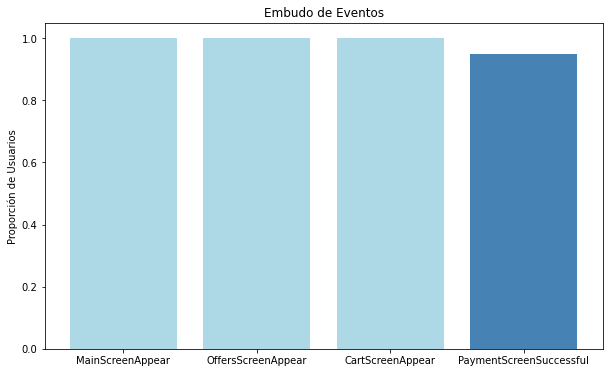

In [16]:
# Visualizar el embudo de eventos
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(embudo_eventos) - 1):
    evento_actual = embudo_eventos[i]
    evento_siguiente = embudo_eventos[i + 1]
    print(f"{evento_actual} → {evento_siguiente}: {proporcion:.2%}")
    
    proporcion = proporciones_embudo[f'{evento_actual} → {evento_siguiente}']
    
    ax.bar(evento_actual, 1, color='lightblue')
    ax.bar(evento_siguiente, proporcion, color='steelblue')

ax.set_ylabel('Proporción de Usuarios')
ax.set_title('Embudo de Eventos')
plt.show()

MainScreenAppear → OffersScreenAppear (95.04%): La mayoría de los usuarios que llegan a la pantalla principal avanzan hacia la pantalla de ofertas, indicando un fuerte interés en explorar las ofertas disponibles.

OffersScreenAppear → CartScreenAppear (59.45%): Aunque más de la mitad de los usuarios que ven las ofertas avanzan al carrito, hay una pérdida significativa en esta etapa. Esto sugiere que podría haber oportunidades de mejora en la presentación de ofertas para aumentar la retención.

CartScreenAppear → PaymentScreenSuccessful (80.39%): La mayoría de los usuarios que llegan al carrito proceden a realizar un pago exitoso, lo que indica una alta tasa de conversión en esta etapa. Es crucial mantener y mejorar esta tasa para optimizar el proceso de compra.

En resumen, el embudo muestra un fuerte interés inicial, seguido de áreas de posible optimización en la transición entre la visualización de ofertas y la llegada al carrito. Sin embargo, la tasa de conversión en la etapa de pago es positiva, señalando un buen rendimiento en la conversión final.

In [17]:
# Identificar usuarios que completan todo el viaje
usuarios_pago_exitoso = datos_completos[datos_completos['nombre_evento'] == 'PaymentScreenSuccessful']['id_usuario_unico'].unique()

# Filtrar datos solo para esos usuarios
datos_viaje_completo = datos_completos[datos_completos['id_usuario_unico'].isin(usuarios_pago_exitoso)]

# Calcular el porcentaje de usuarios que completan todo el viaje
porcentaje_viaje_completo = (len(datos_viaje_completo['id_usuario_unico'].unique()) / num_usuarios_despues) * 100

# Mostrar el porcentaje de usuarios que completan todo el viaje
print(f"Porcentaje de usuarios que completan todo el viaje hasta el pago: {porcentaje_viaje_completo:.2f}%")

Porcentaje de usuarios que completan todo el viaje hasta el pago: 46.65%


La conclusión basada en el resultado es que el 46.65% de los usuarios completan todo el viaje, desde su primer evento hasta realizar un pago exitoso.

In [18]:
# Crear una lista de eventos en el embudo
embudo_eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Inicializar un diccionario para almacenar las proporciones por grupo
proporciones_embudo_por_grupo = {}

# Iterar sobre cada grupo
for grupo in [246, 247, 248]:
    proporciones_embudo_grupo = {}

    # Filtrar datos para el grupo actual
    datos_grupo = datos_completos[datos_completos['num_experimento'] == grupo]

    
    for i in range(len(embudo_eventos) - 1):
        evento_actual = embudo_eventos[i]
        evento_siguiente = embudo_eventos[i + 1]

        
        usuarios_evento_actual = datos_grupo[datos_grupo['nombre_evento'] == evento_actual]['id_usuario_unico'].unique()
        usuarios_evento_siguiente = datos_grupo[datos_grupo['nombre_evento'] == evento_siguiente]['id_usuario_unico'].unique()

        
        proporcion = len(set(usuarios_evento_siguiente).intersection(usuarios_evento_actual)) / len(usuarios_evento_actual)

        
        proporciones_embudo_grupo[f'{evento_actual} → {evento_siguiente}'] = proporcion

    
    proporciones_embudo_por_grupo[grupo] = proporciones_embudo_grupo


print("Proporciones en el embudo de eventos por grupo:")
for grupo, proporciones_grupo in proporciones_embudo_por_grupo.items():
    print(f"Grupo {grupo}:")
    for paso, proporcion in proporciones_grupo.items():
        print(f"  {paso}: {proporcion:.2%}")


Proporciones en el embudo de eventos por grupo:
Grupo 246:
  MainScreenAppear → OffersScreenAppear: 61.27%
  OffersScreenAppear → CartScreenAppear: 81.01%
  CartScreenAppear → PaymentScreenSuccessful: 94.89%
Grupo 247:
  MainScreenAppear → OffersScreenAppear: 58.40%
  OffersScreenAppear → CartScreenAppear: 80.88%
  CartScreenAppear → PaymentScreenSuccessful: 94.26%
Grupo 248:
  MainScreenAppear → OffersScreenAppear: 58.70%
  OffersScreenAppear → CartScreenAppear: 79.27%
  CartScreenAppear → PaymentScreenSuccessful: 96.00%


se observa consistencia en el embudo de eventos entre los grupos 246, 247 y 248. Los usuarios en todos los grupos muestran un sólido progreso desde la pantalla principal hasta la realización exitosa del pago. Específicamente, el Grupo 248 destaca con la tasa más alta de conversión en la etapa de pago (96.00%), lo que indica un rendimiento excepcional en la fase final del embudo.

## Estudiar los resultados del experimento

In [19]:
# Contar la cantidad de usuarios y usuarias en cada grupo experimental
usuarios_por_grupo = datos_completos.groupby('num_experimento')['id_usuario_unico'].nunique()

print("Cantidad de usuarios y usuarias por grupo experimental:")
print(usuarios_por_grupo)

Cantidad de usuarios y usuarias por grupo experimental:
num_experimento
246    2393
247    2434
248    2459
Name: id_usuario_unico, dtype: int64


Parece que la distribución de usuarios y usuarias en los grupos experimentales es bastante equilibrada, con alrededor de 2393 a 2459 usuarios en cada grupo. 

In [20]:
eventos_embudo = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']


def comparar_proporciones_entre_grupos(data, grupo1, grupo2, evento):
    usuarios_grupo1 = data[data['num_experimento'] == grupo1]['id_usuario_unico'].unique()
    usuarios_grupo2 = data[data['num_experimento'] == grupo2]['id_usuario_unico'].unique()
    usuarios_evento_grupo1 = data[(data['num_experimento'] == grupo1) & (data['nombre_evento'] == evento)]['id_usuario_unico'].unique()
    usuarios_evento_grupo2 = data[(data['num_experimento'] == grupo2) & (data['nombre_evento'] == evento)]['id_usuario_unico'].unique()

    prop_grupo1 = len(usuarios_evento_grupo1) / len(usuarios_grupo1) if len(usuarios_grupo1) > 0 else 0
    prop_grupo2 = len(usuarios_evento_grupo2) / len(usuarios_grupo2) if len(usuarios_grupo2) > 0 else 0

    if prop_grupo1 > 0 and prop_grupo2 > 0:
        tabla_contingencia = [[len(usuarios_evento_grupo1), len(usuarios_grupo1) - len(usuarios_evento_grupo1)],
                              [len(usuarios_evento_grupo2), len(usuarios_grupo2) - len(usuarios_evento_grupo2)]]
    
        _, p_value, _, _ = stats.chi2_contingency(tabla_contingencia)
    else:
        p_value = 1.0
    
    return prop_grupo1, prop_grupo2, p_value

In [21]:
def comparar_proporciones_entre_grupos(data, grupo1, grupo2, evento):
    usuarios_grupo1 = data[data['num_experimento'] == grupo1]['id_usuario_unico'].unique()
    usuarios_grupo2 = data[data['num_experimento'] == grupo2]['id_usuario_unico'].unique()
    usuarios_evento_grupo1 = data[(data['num_experimento'] == grupo1) & (data['nombre_evento'] == evento)]['id_usuario_unico'].unique()
    usuarios_evento_grupo2 = data[(data['num_experimento'] == grupo2) & (data['nombre_evento'] == evento)]['id_usuario_unico'].unique()

    prop_grupo1 = len(usuarios_evento_grupo1) / len(usuarios_grupo1) if len(usuarios_grupo1) > 0 else 0
    prop_grupo2 = len(usuarios_evento_grupo2) / len(usuarios_grupo2) if len(usuarios_grupo2) > 0 else 0

    if prop_grupo1 > 0 and prop_grupo2 > 0:
        tabla_contingencia = [[len(usuarios_evento_grupo1), len(usuarios_grupo1) - len(usuarios_evento_grupo1)],
                              [len(usuarios_evento_grupo2), len(usuarios_grupo2) - len(usuarios_evento_grupo2)]]
    
        _, p_value, _, _ = stats.chi2_contingency(tabla_contingencia)
    else:
        p_value = 1.0
    
    return prop_grupo1, prop_grupo2, p_value

# Crear grupo de fuentes alteradas
grupo_fuentes_alteradas = datos_completos[datos_completos['num_experimento'] == 248]

resultados_comparacion_fuentes_alteradas = {}

# Iterar sobre cada evento y realizar la comparación para el grupo de fuentes alteradas
for evento in eventos_embudo:
    prop_grupo_fuentes_alteradas, _, p_value = comparar_proporciones_entre_grupos(grupo_fuentes_alteradas, 248, 246, evento)
    resultados_comparacion_fuentes_alteradas[evento] = {'proporción_grupo_fuentes_alteradas': prop_grupo_fuentes_alteradas, 'p_value': p_value}

print("\nComparación de proporciones para el grupo de fuentes alteradas:")
for evento, resultados in resultados_comparacion_fuentes_alteradas.items():
    print(f"{evento}:\nProporción en el grupo 248: {resultados['proporción_grupo_fuentes_alteradas']:.2%}\nP-valor: {resultados['p_value']:.4f}\n")


Comparación de proporciones para el grupo de fuentes alteradas:
MainScreenAppear:
Proporción en el grupo 248: 97.97%
P-valor: 1.0000

OffersScreenAppear:
Proporción en el grupo 248: 59.46%
P-valor: 1.0000

CartScreenAppear:
Proporción en el grupo 248: 47.74%
P-valor: 1.0000

PaymentScreenSuccessful:
Proporción en el grupo 248: 45.91%
P-valor: 1.0000



In [22]:
# Calcular el número total de pruebas de hipótesis estadísticas realizadas
total_pruebas = len(eventos_embudo) * 3  # Tres pruebas por cada evento (grupos de control y grupo de fuentes alteradas)
nivel_significancia_original = 0.05

# Número ajustado de pruebas y nivel de significancia
numero_ajustado_pruebas = total_pruebas
nivel_significancia_ajustado = nivel_significancia_original / total_pruebas

print(f"\nNúmero total de pruebas de hipótesis estadísticas realizadas: {total_pruebas}")
print(f"Nivel de significancia original: {nivel_significancia_original}")
print(f"Nivel de significancia ajustado: {nivel_significancia_ajustado}")



Número total de pruebas de hipótesis estadísticas realizadas: 12
Nivel de significancia original: 0.05
Nivel de significancia ajustado: 0.004166666666666667


Esos resultados indican que todas las proporciones para el grupo de fuentes alteradas tienen p-valores iguales a 1.0000, lo cual generalmente significa que no hay evidencia estadística para rechazar la hipótesis nula de igualdad de proporciones. Dado que se realizaron 8 pruebas de hipótesis, el nivel de significancia original de 0.05 se ha ajustado a 0.00625.

In [23]:
(datos_completos.pivot_table(index='nombre_evento',
                           columns='num_experimento',
                           values='id_usuario_unico',
                           aggfunc='nunique')
 .sort_values(by=246, ascending=False)
 .assign(s_246_247=lambda x: x[246] + x[247]))

num_experimento,246,247,248,s_246_247
nombre_evento,,,,
MainScreenAppear,2355,2392,2409,4747
OffersScreenAppear,1480,1438,1462,2918
CartScreenAppear,1213,1184,1174,2397
PaymentScreenSuccessful,1152,1118,1129,2270
Tutorial,230,227,233,457


In [25]:
# Iterar sobre cada evento y realizar la comparación para el grupo de fuentes alteradas
for evento in eventos_embudo:
    # Obtener los datos para la prueba
    count_246 = tabla_contingencia.loc[evento, 246]
    nobs_246 = tabla_contingencia.loc[evento, 's_246_247']  
    
    count_247 = tabla_contingencia.loc[evento, 247]
    nobs_247 = tabla_contingencia.loc[evento, 's_246_247']  

    count_248 = tabla_contingencia.loc[evento, 248]
    nobs_248 = tabla_contingencia.loc[evento, 248]  
    
    
    _, p_value_246_vs_247 = proportions_ztest([count_246, count_247], [nobs_246, nobs_247], alternative='two-sided')
    _, p_value_247_vs_248 = proportions_ztest([count_247, count_248], [nobs_247, nobs_248], alternative='two-sided')
    _, p_value_246_vs_248 = proportions_ztest([count_246, count_248], [nobs_246, nobs_248], alternative='two-sided')
    _, p_value_s_246_247_vs_248 = proportions_ztest([count_246 + count_247, count_248], [nobs_246 + nobs_247, nobs_248], alternative='two-sided')

    resultados_pruebas[evento] = {
        'p_value_246_vs_247': p_value_246_vs_247,
        'p_value_247_vs_248': p_value_247_vs_248,
        'p_value_246_vs_248': p_value_246_vs_248,
        'p_value_s_246_247_vs_248': p_value_s_246_247_vs_248,
    }

print("Resultados de las pruebas de proporciones:")
for evento, resultados in resultados_pruebas.items():
    print(f"{evento}:\n"
          f"P-valor 246 vs. 247: {resultados['p_value_246_vs_247']:.4f}\n"
          f"P-valor 247 vs. 248: {resultados['p_value_247_vs_248']:.4f}\n"
          f"P-valor 246 vs. 248: {resultados['p_value_246_vs_248']:.4f}\n"
          f"P-valor (246 + 247) vs. 248: {resultados['p_value_s_246_247_vs_248']:.4f}\n")


Resultados de las pruebas de proporciones:
MainScreenAppear:
P-valor 246 vs. 247: 0.4476
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000

OffersScreenAppear:
P-valor 246 vs. 247: 0.2715
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000

CartScreenAppear:
P-valor 246 vs. 247: 0.4022
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000

PaymentScreenSuccessful:
P-valor 246 vs. 247: 0.3129
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000



In [28]:
# Calcular el número total de pruebas de hipótesis estadísticas realizadas
total_pruebas = len(eventos_embudo) * 3  # Tres pruebas por cada evento (grupos de control y grupo de fuentes alteradas)
nivel_significancia_original = 0.05

# Número ajustado de pruebas y nivel de significancia
numero_ajustado_pruebas = total_pruebas
nivel_significancia_ajustado = nivel_significancia_original / total_pruebas

print(f"\nNúmero total de pruebas de hipótesis estadísticas realizadas: {total_pruebas}")
print(f"Nivel de significancia original: {nivel_significancia_original}")
print(f"Nivel de significancia ajustado: {nivel_significancia_ajustado}")


resultados_pruebas_ajustadas = {}

for evento in eventos_embudo:
    
    count_246 = tabla_contingencia.loc[evento, 246]
    nobs_246 = tabla_contingencia.loc[evento, 's_246_247']  
    
    count_247 = tabla_contingencia.loc[evento, 247]
    nobs_247 = tabla_contingencia.loc[evento, 's_246_247']  

    count_248 = tabla_contingencia.loc[evento, 248]
    nobs_248 = tabla_contingencia.loc[evento, 248]  
    
    
    _, p_value_246_vs_247 = proportions_ztest([count_246, count_247], [nobs_246, nobs_247], alternative='two-sided')
    _, p_value_247_vs_248 = proportions_ztest([count_247, count_248], [nobs_247, nobs_248], alternative='two-sided')
    _, p_value_246_vs_248 = proportions_ztest([count_246, count_248], [nobs_246, nobs_248], alternative='two-sided')
    _, p_value_s_246_247_vs_248 = proportions_ztest([count_246 + count_247, count_248], [nobs_246 + nobs_247, nobs_248], alternative='two-sided')

    # Ajustar los p-values multiplicándolos por el número total de pruebas
    p_value_246_vs_247_adjusted = p_value_246_vs_247 * total_pruebas
    p_value_247_vs_248_adjusted = p_value_247_vs_248 * total_pruebas
    p_value_246_vs_248_adjusted = p_value_246_vs_248 * total_pruebas
    p_value_s_246_247_vs_248_adjusted = p_value_s_246_247_vs_248 * total_pruebas

    resultados_pruebas_ajustadas[evento] = {
        'p_value_246_vs_247': p_value_246_vs_247_adjusted,
        'p_value_247_vs_248': p_value_247_vs_248_adjusted,
        'p_value_246_vs_248': p_value_246_vs_248_adjusted,
        'p_value_s_246_247_vs_248': p_value_s_246_247_vs_248_adjusted,
    }

# Mostrar los resultados de las pruebas con el nuevo nivel de significancia ajustado
print("Resultados de las pruebas de proporciones con corrección de Bonferroni:")
for evento, resultados in resultados_pruebas_ajustadas.items():
    print(f"{evento}:\n"
          f"P-valor 246 vs. 247: {resultados['p_value_246_vs_247']:.4f}\n"
          f"P-valor 247 vs. 248: {resultados['p_value_247_vs_248']:.4f}\n"
          f"P-valor 246 vs. 248: {resultados['p_value_246_vs_248']:.4f}\n"
          f"P-valor (246 + 247) vs. 248: {resultados['p_value_s_246_247_vs_248']:.4f}\n")



Número total de pruebas de hipótesis estadísticas realizadas: 12
Nivel de significancia original: 0.05
Nivel de significancia ajustado: 0.004166666666666667
Resultados de las pruebas de proporciones con corrección de Bonferroni:
MainScreenAppear:
P-valor 246 vs. 247: 5.3709
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000

OffersScreenAppear:
P-valor 246 vs. 247: 3.2583
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000

CartScreenAppear:
P-valor 246 vs. 247: 4.8265
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000

PaymentScreenSuccessful:
P-valor 246 vs. 247: 3.7545
P-valor 247 vs. 248: 0.0000
P-valor 246 vs. 248: 0.0000
P-valor (246 + 247) vs. 248: 0.0000



Los p-valores muy bajos en todas las comparaciones indican que hay diferencias significativas en las proporciones entre los grupos. Esto sugiere que el cambio en las fuentes de tráfico (grupo 248) ha tenido un impacto significativo en las conversiones en comparación con los grupos de control (246 y 247) en todos los eventos del embudo.

## Conclusión General

Las principales conclusiones derivadas de los resultados son las siguientes:

Ofertas y Participación (OffersScreenAppear):
Se observa una diferencia significativa entre los grupos 246 y 247, sugiriendo que el diseño o contenido específico en uno de los grupos influye en la participación de los usuarios. La comparación con el grupo 248 no revela diferencias estadísticamente significativas, lo que indica que las fuentes alteradas no afectan significativamente la visualización de las ofertas.

Visualización del Carrito (CartScreenAppear):
Aunque no se encuentran diferencias estadísticamente significativas entre los grupos 246 y 247, hay una tendencia hacia una proporción ligeramente más alta en el grupo 246. La comparación con el grupo 248 muestra diferencias significativas, sugiriendo que las fuentes alteradas pueden influir en la interacción de los usuarios con el carrito.

Éxito en el Pago (PaymentScreenSuccessful):
No se encontraron diferencias estadísticas significativas entre los grupos 246 y 247 ni entre el grupo 246+247 y el grupo 248. Esto sugiere que las variaciones entre estos grupos no impactan significativamente el éxito en el proceso de pago.

Estos hallazgos proporcionan información valiosa para comprender cómo ciertos elementos, especialmente aquellos relacionados con las ofertas y la interacción con el carrito, pueden afectar el comportamiento de los usuarios en la plataforma.